# Google Analytics Customer Revenue

## Import libreries

In [1]:
import sys
import os

In [2]:
import numpy as np
import pandas as pd

#visualizaciones

import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_rows = 100
plt.style.use('ggplot')

In [3]:
from sklearn import model_selection
import xgboost as xgb
from datetime import datetime

In [4]:
# nuevos librerias

import random
import json
from pandas.io.json import json_normalize

In [5]:
RANDOM_STATE = 42

In [6]:
columns = ['device', 'geoNetwork', 'totals'] # Columns with json format

p = 0.1 # Fraction of data to use

def json_read(df):
    data_frame = file_dir + df
    
    df = pd.read_csv(data_frame, 
                     converters={column: json.loads for column in columns}, 
                     dtype={'fullVisitorId': 'str'}, 
                     skiprows=lambda i: i>0 and random.random() > p)
    
    for column in columns: 
        column_as_df = json_normalize(df[column]) 
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns] 
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
        
    print(f"Loaded {os.path.basename(data_frame)}. Shape: {df.shape}")
    return df

In [7]:
file_dir = ''
file_name = 'GACR_def.csv'

In [8]:
%%time

df = json_read(file_name)

<ipython-input-6-38b9501691c8>:14: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  column_as_df = json_normalize(df[column])
Loaded GACR_def.csv. Shape: (90517, 42)
Wall time: 13.7 s


## Analisis dataset

In [9]:
df.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90517 entries, 0 to 90516
Columns: 42 entries, Unnamed: 0 to totals.transactionRevenue
dtypes: bool(1), int64(5), object(36)
memory usage: 28.4+ MB


In [10]:
df.head().T

,0,1,2,3,4
Unnamed: 0,6,12,23,30,50
channelGrouping,Organic Search,Organic Search,Organic Search,Organic Search,Organic Search
date,20160902,20160902,20160902,20160902,20160902
fullVisitorId,1905672039242460897,357659889600827884,3053576296023059465,602999120596767867,5280028223552107612
sessionId,1905672039242460897_1472817241,357659889600827884_1472839882,3053576296023059465_1472808484,602999120596767867_1472811390,5280028223552107612_1472820135
socialEngagementType,Not Socially Engaged,Not Socially Engaged,Not Socially Engaged,Not Socially Engaged,Not Socially Engaged
visitId,1472817241,1472839882,1472808484,1472811390,1472820135
visitNumber,1,1,1,1,1
visitStartTime,1472817241,1472839882,1472808484,1472811390,1472820135
device.browser,Chrome,Safari,Chrome,Chrome,Chrome


In [11]:
df.drop('Unnamed: 0', axis = 1, inplace = True)

In [12]:
#me quedo con el session id como identificador unico de fila

df.set_index('sessionId', inplace= True)

In [13]:
id_columns = ['fullVisitorId','visitId']
df.drop(id_columns, axis = 1, inplace = True)

## Analisis exploratorio de variables

In [14]:
df.describe(include = np.number).T

,count,mean,std,min,25%,50%,75%,max
date,90517.0,2.016588e+07,4.697915e+03,2.016080e+07,2.016103e+07,2.017011e+07,2.017042e+07,2.017080e+07
visitNumber,90517.0,2.301104e+00,9.614016e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.940000e+02
visitStartTime,90517.0,1.484985e+09,9.022814e+06,1.470035e+09,1.477561e+09,1.483901e+09,1.492712e+09,1.501656e+09


In [15]:
df.describe(exclude = np.number).T

,count,unique,top,freq
channelGrouping,90517,8,Organic Search,38261
socialEngagementType,90517,1,Not Socially Engaged,90517
device.browser,90517,33,Chrome,62003
device.browserVersion,90517,1,not available in demo dataset,90517
device.browserSize,90517,1,not available in demo dataset,90517
device.operatingSystem,90517,16,Windows,35147
device.operatingSystemVersion,90517,1,not available in demo dataset,90517
device.isMobile,90517,2,False,66662
device.mobileDeviceBranding,90517,1,not available in demo dataset,90517
device.mobileDeviceModel,90517,1,not available in demo dataset,90517


In [16]:
df.columns

Index(['channelGrouping', 'date', 'socialEngagementType', 'visitNumber',
       'visitStartTime', 'device.browser', 'device.browserVersion',
       'device.browserSize', 'device.operatingSystem',
       'device.operatingSystemVersion', 'device.isMobile',
       'device.mobileDeviceBranding', 'device.mobileDeviceModel',
       'device.mobileInputSelector', 'device.mobileDeviceInfo',
       'device.mobileDeviceMarketingName', 'device.flashVersion',
       'device.language', 'device.screenColors', 'device.screenResolution',
       'device.deviceCategory', 'geoNetwork.continent',
       'geoNetwork.subContinent', 'geoNetwork.country', 'geoNetwork.region',
       'geoNetwork.metro', 'geoNetwork.city', 'geoNetwork.cityId',
       'geoNetwork.networkDomain', 'geoNetwork.latitude',
       'geoNetwork.longitude', 'geoNetwork.networkLocation', 'totals.visits',
       'totals.hits', 'totals.pageviews', 'totals.bounces', 'totals.newVisits',
       'totals.transactionRevenue'],
      dtype='object'

In [17]:
df['device.browserVersion'].nunique()

1

In [18]:
constant_columns = []

for columns in df.columns:

    if df[columns].nunique() == 1:
        constant_columns.append(columns)

In [19]:
constant_columns

['socialEngagementType',
 'device.browserVersion',
 'device.browserSize',
 'device.operatingSystemVersion',
 'device.mobileDeviceBranding',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.flashVersion',
 'device.language',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'totals.bounces',
 'totals.newVisits']

In [20]:
df.drop(constant_columns, axis =1 , inplace = True)

In [21]:
df_description = df.describe(include = 'all').T

In [22]:
#df_description.to_excel('df_description.xlsx')

## Target Analysis

In [23]:
TARGET = 'totals.transactionRevenue'

In [24]:
df[TARGET].describe()

count         1116
unique         795
top       18990000
freq            25
Name: totals.transactionRevenue, dtype: object

In [25]:
# el target esta en formato object
# hay muchos nulos que en realidad son no compras = 0
# valor del importe esta multiplicado por 1000000

In [26]:
#cambiar formato
df[TARGET] = df[TARGET].astype(float)

In [27]:
# hay nulos

df[TARGET].fillna(0.0, inplace = True)

In [28]:
#corregir el valor del importe

df[TARGET] = df[TARGET]/1000000

In [29]:
df[TARGET].describe()

count    90517.000000
mean         1.827610
std         46.269145
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       6826.960000
Name: totals.transactionRevenue, dtype: float64

In [30]:
df[df[TARGET]>0][TARGET].describe()

count    1116.000000
mean      148.234552
std       389.963375
min         0.090000
25%        26.590000
50%        49.975000
75%       117.505000
max      6826.960000
Name: totals.transactionRevenue, dtype: float64

In [31]:
df[TARGET]>0

sessionId
1905672039242460897_1472817241    False
357659889600827884_1472839882     False
3053576296023059465_1472808484    False
602999120596767867_1472811390     False
5280028223552107612_1472820135    False
                                  ...  
5139693001636159357_1483581821    False
8316382343226738015_1483549157    False
7822582517551956770_1483534287    False
015965500276524997_1483556696     False
7660319315190231588_1483548841    False
Name: totals.transactionRevenue, Length: 90517, dtype: bool

In [32]:
df['visitWithTransaction'] = (df[TARGET]>0).astype(int)

In [33]:
count_transac = df['visitWithTransaction'].count()
sum_transac = df['visitWithTransaction'].sum()
mean_transac = df['visitWithTransaction'].mean()

In [34]:
print(f'Hay un total de {count_transac} visitas, de las cuales {sum_transac} acaban con compra, lo que representa un {round(mean_transac*100,1)} %')

Hay un total de 90517 visitas, de las cuales 1116 acaban con compra, lo que representa un 1.2 %


<Figure size 1080x360 with 0 Axes>

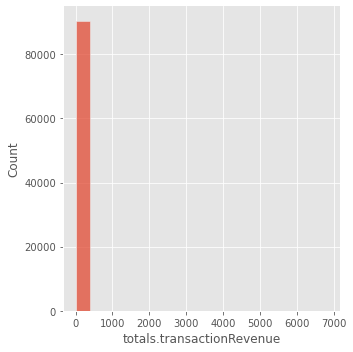

In [35]:
plt.figure(figsize=(15,5))
sns.displot(df[TARGET])

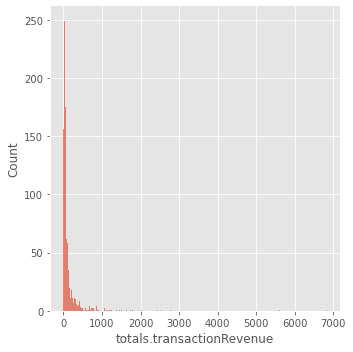

In [36]:
sns.displot(df[df['visitWithTransaction'] == 1][TARGET])

In [37]:
#opcion 1
df['total.transactionRevenueLN'] = df[TARGET].apply(lambda x: np.log1p(x))

In [38]:
TARGET_LN = 'total.transactionRevenueLN'

In [39]:
#opcion 2
np.log1p(df[TARGET])

sessionId
1905672039242460897_1472817241    0.0
357659889600827884_1472839882     0.0
3053576296023059465_1472808484    0.0
602999120596767867_1472811390     0.0
5280028223552107612_1472820135    0.0
                                 ... 
5139693001636159357_1483581821    0.0
8316382343226738015_1483549157    0.0
7822582517551956770_1483534287    0.0
015965500276524997_1483556696     0.0
7660319315190231588_1483548841    0.0
Name: totals.transactionRevenue, Length: 90517, dtype: float64

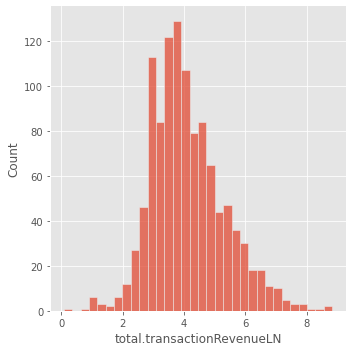

In [40]:
sns.displot(df[df['visitWithTransaction'] == 1][TARGET_LN])

## ML EDA

## Categóricas

### Device browser

In [41]:
top_browser = df['device.browser'].value_counts().head(3)

In [42]:
top_browser_list = top_browser.index.to_list()

In [43]:
top_browser_list.append('Others')

In [44]:
top_browser_list

['Chrome', 'Safari', 'Firefox', 'Others']

In [45]:
df['device.browser'] = pd.Categorical(df['device.browser'], categories= top_browser_list)

In [46]:
df['device.browser'].value_counts(dropna = False)

Chrome     62003
Safari     18329
NaN         6451
Firefox     3734
Others         0
Name: device.browser, dtype: int64

In [47]:
df['device.browser'].fillna('Others', inplace = True)

In [48]:
df['device.browser'].value_counts(dropna = False)

Chrome     62003
Safari     18329
Others      6451
Firefox     3734
Name: device.browser, dtype: int64

In [49]:
def setOthers(dataframe, column, num_value):
    top_categories = dataframe[column].value_counts().head(num_value)
    top_categories_list = top_categories.index.to_list()
    top_categories_list.append('Others')
    dataframe[column] = pd.Categorical(dataframe[column], categories= top_categories_list)
    return dataframe[column].fillna('Others')

In [50]:
browser_result_df = df[df['visitWithTransaction'] == 1].pivot_table(index = 'device.browser', values = TARGET_LN, aggfunc = [len, np.mean])

In [51]:
browser_result_df

,len,mean
,total.transactionRevenueLN,total.transactionRevenueLN
device.browser,,
Chrome,1008.0,4.149693
Safari,69.0,3.635472
Firefox,21.0,4.346004
Others,18.0,3.630747


In [52]:
# la mayoria de compras vienen por chrome
# los de firefox parece que se gastan más 

In [53]:
browser_result_df.columns = ['transaction','mean_ln_revenue']

In [54]:
browser_result_df

,transaction,mean_ln_revenue
device.browser,,
Chrome,1008.0,4.149693
Safari,69.0,3.635472
Firefox,21.0,4.346004
Others,18.0,3.630747


In [55]:
browser_result_df['nrows'] = df['device.browser'].value_counts()

In [56]:
browser_result_df['pct_rows'] = df['device.browser'].value_counts(normalize = True)

In [57]:
browser_result_df['pct_transaction'] = browser_result_df['transaction'] / browser_result_df['nrows']

In [58]:
browser_result_df = browser_result_df[['nrows', 'pct_rows', 'transaction','pct_transaction','mean_ln_revenue']]

In [59]:
browser_result_df

,nrows,pct_rows,transaction,pct_transaction,mean_ln_revenue
device.browser,,,,,
Chrome,62003,0.684987,1008.0,0.016257,4.149693
Safari,18329,0.202492,69.0,0.003765,3.635472
Firefox,3734,0.041252,21.0,0.005624,4.346004
Others,6451,0.071268,18.0,0.002790,3.630747


In [60]:
def explore_cat_values(dataframe, column):
    _result_df = dataframe[dataframe['visitWithTransaction'] == 1].pivot_table(index = column, values = TARGET_LN, aggfunc = [len, np.mean])
    _result_df.columns = ['transaction','mean_ln_revenue']
    _result_df['nrows'] = dataframe[column].value_counts()
    _result_df['pct_rows'] = dataframe[column].value_counts(normalize = True)
    _result_df['pct_transaction'] = _result_df['transaction'] / _result_df['nrows']
    _result_df = _result_df[['nrows', 'pct_rows', 'transaction','pct_transaction','mean_ln_revenue']]

    return _result_df

In [61]:
explore_cat_values(df, 'device.browser')

,nrows,pct_rows,transaction,pct_transaction,mean_ln_revenue
device.browser,,,,,
Chrome,62003,0.684987,1008.0,0.016257,4.149693
Safari,18329,0.202492,69.0,0.003765,3.635472
Firefox,3734,0.041252,21.0,0.005624,4.346004
Others,6451,0.071268,18.0,0.002790,3.630747


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='device.browser', ylabel='count'>

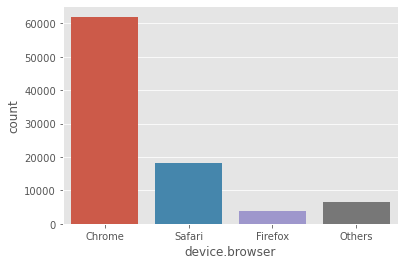

In [62]:
sns.countplot(df['device.browser'])

<AxesSubplot:xlabel='device.browser', ylabel='total.transactionRevenueLN'>

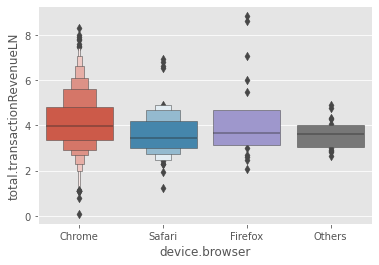

In [63]:
sns.boxenplot(
    data = df[df['visitWithTransaction'] == 1],
    x = 'device.browser',
    y= TARGET_LN
)

In [64]:
def plot_cat_values(dataframe, column):

    plt.figure(figsize=(15,8))

    ax1 = plt.subplot(2,1,1) #una imagen con dos plots por fila, 1 plot por columna, el ax1 es el primer plot
    #grafico 1 count
    ax1 = sns.countplot(
         dataframe[column],
         order = list(dataframe[column].unique())

        )

    #grafico 2 distribucion del importe entre los que compran

    ax2 = plt.subplot(2,1,2)
    ax2 = sns.boxenplot(
    data = dataframe[dataframe['visitWithTransaction'] == 1],
    x = column,
    y= TARGET_LN,
    order = list(dataframe[column].unique())
    )

    plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


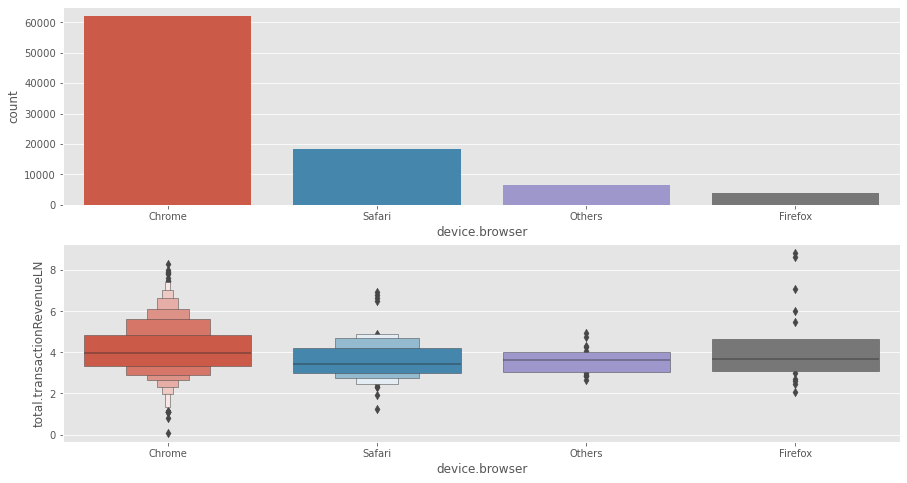

In [65]:
plot_cat_values(df, 'device.browser')

### device.operatingSystem

In [66]:
df['device.operatingSystem'].value_counts()

Windows          35147
Macintosh        25471
Android          12346
iOS              10730
Linux             3549
Chrome OS         2611
(not set)          472
Windows Phone      116
Samsung             24
BlackBerry          19
Xbox                11
Firefox OS           9
Nintendo Wii         7
Nintendo WiiU        2
FreeBSD              2
Nokia                1
Name: device.operatingSystem, dtype: int64

In [67]:
df['device.operatingSystem'] = setOthers(df, 'device.operatingSystem', 6)

In [68]:
df['device.operatingSystem'].value_counts()

Windows      35147
Macintosh    25471
Android      12346
iOS          10730
Linux         3549
Chrome OS     2611
Others         663
Name: device.operatingSystem, dtype: int64

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


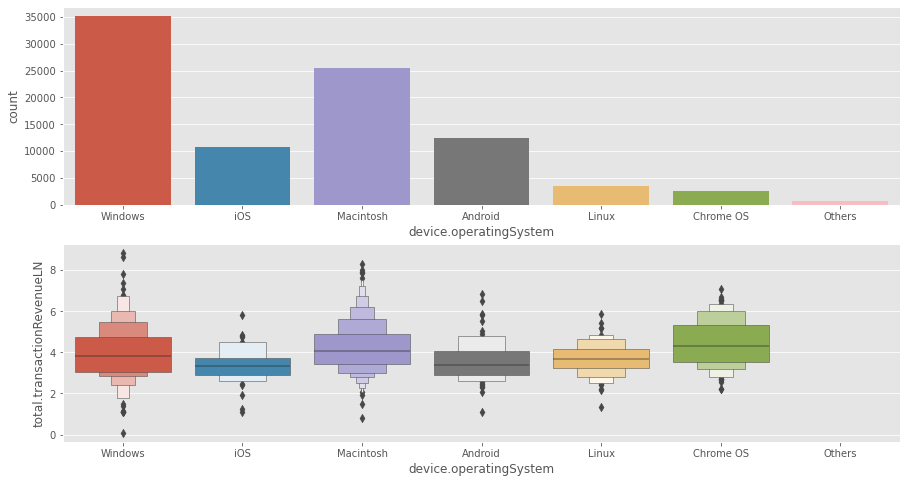

In [69]:
plot_cat_values(df, 'device.operatingSystem')

In [70]:
# conclusiones:
    # chrome OS se gastan más de media --> importe x:  log(x+1) funcion numpy np.log1p()


### device.isMobile


In [71]:
explore_cat_values(df, 'device.isMobile')

,nrows,pct_rows,transaction,pct_transaction,mean_ln_revenue
device.isMobile,,,,,
False,66662,0.736458,1021.0,0.015316,4.169229
True,23855,0.263542,95.0,0.003982,3.511314


In [72]:
#conclusiones: 
    # hay más gente que me entra por no mobil
    # más gente que me compra por no mobil
    # se gastan más los de no mobil

In [73]:
df['device.isMobile'] = df['device.isMobile'].astype(int)

### device.deviceCategory


In [74]:
explore_cat_values(df, 'device.deviceCategory')

,nrows,pct_rows,transaction,pct_transaction,mean_ln_revenue
device.deviceCategory,,,,,
desktop,66665,0.736491,1021.0,0.015315,4.169229
mobile,20808,0.229879,79.0,0.003797,3.536203
tablet,3044,0.033629,16.0,0.005256,3.388424


In [75]:
pd.crosstab(df['device.isMobile'],df['device.deviceCategory'])

device.deviceCategory,desktop,mobile,tablet
device.isMobile,,,
0,66649,11,2
1,16,20797,3042


In [76]:
#conclusion: isMobile y deviceCategory tienen casi la misma información, por lo tanto me puedo quedar con una variable

In [77]:
df.drop('device.isMobile', axis = 1, inplace = True)

#### channelGrouping


In [78]:
explore_cat_values(df, 'channelGrouping')

,nrows,pct_rows,transaction,pct_transaction,mean_ln_revenue
channelGrouping,,,,,
Direct,14320,0.158202,183.0,0.012779,4.340911
Display,613,0.006772,17.0,0.027732,5.412067
Organic Search,38261,0.422694,326.0,0.008520,3.821771
Paid Search,2478,0.027376,46.0,0.018563,3.852946
Referral,10478,0.115757,536.0,0.051155,4.196698
Social,22779,0.251654,8.0,0.000351,3.925324


In [79]:
# conclusiones:
# 7 etiquetas OHE 

### Fechas

In [80]:
df['date'].describe()

count    9.051700e+04
mean     2.016588e+07
std      4.697915e+03
min      2.016080e+07
25%      2.016103e+07
50%      2.017011e+07
75%      2.017042e+07
max      2.017080e+07
Name: date, dtype: float64

In [81]:
df['date'].head()

sessionId
1905672039242460897_1472817241    20160902
357659889600827884_1472839882     20160902
3053576296023059465_1472808484    20160902
602999120596767867_1472811390     20160902
5280028223552107612_1472820135    20160902
Name: date, dtype: int64

In [82]:
df['date'] = pd.to_datetime(df['date'], format = '%Y%m%d')

In [83]:
df['Year'] = df['date'].dt.year
df['Month'] = df['date'].dt.month
df['Day'] = df['date'].dt.day
df['Weekday'] = df['date'].dt.weekday
df['Week'] = df['date'].dt.week
df['Season'] = df['date'].dt.quarter

<ipython-input-83-7ed55bf8f7fb>:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['Week'] = df['date'].dt.week


In [84]:
df.drop('date', axis = 1, inplace = True)

### Visit start time

In [85]:
df['visitStartTime'].head()

sessionId
1905672039242460897_1472817241    1472817241
357659889600827884_1472839882     1472839882
3053576296023059465_1472808484    1472808484
602999120596767867_1472811390     1472811390
5280028223552107612_1472820135    1472820135
Name: visitStartTime, dtype: int64

In [86]:
from datetime import datetime

In [87]:
datetime.fromtimestamp(1472880147)

datetime.datetime(2016, 9, 3, 7, 22, 27)

In [88]:
datetime.fromtimestamp(1472880147).hour

7

In [89]:
df['visitHour'] = df['visitStartTime'].apply(lambda x: datetime.fromtimestamp(x).hour)

In [90]:
pd.set_option.display_row = 20

In [91]:
df[df[TARGET] > 0].pivot_table(index = 'visitHour', values = TARGET, aggfunc = [len, np.mean])

,len,mean
,totals.transactionRevenue,totals.transactionRevenue
visitHour,,
0,74.0,125.920811
1,56.0,136.856786
2,57.0,95.360526
3,50.0,85.487400
4,43.0,158.016512
5,40.0,86.137250
6,22.0,89.375000
7,18.0,35.632222


In [92]:
# conclusiones: vemos que la gente compra más por la tarde-noche y se gastan más a las 16h

## Analisis de variables numéricas

### visitNumber

In [93]:
df['visitNumber'].describe().T

count    90517.000000
mean         2.301104
std          9.614016
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        394.000000
Name: visitNumber, dtype: float64

In [94]:
# 75% (como mínimo) de mis usuarios tienen solo una visita

<AxesSubplot:xlabel='visitNumber', ylabel='total.transactionRevenueLN'>

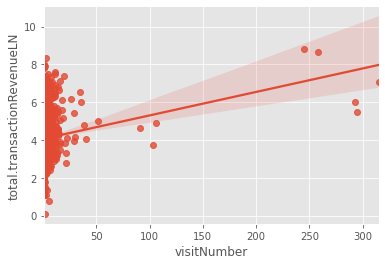

In [95]:
sns.regplot(
    data = df[df[TARGET]>0],
    x = 'visitNumber',
    y = TARGET_LN
)

In [96]:
df['visitNumberLN'] = df['visitNumber'].apply(lambda x: np.log1p(x))

In [97]:
# visitNumberLN la puedo dejar para el decision tree, porque el dt es robusto a variables redundantes (random forest, gradient boosting)

<AxesSubplot:xlabel='visitNumberLN', ylabel='total.transactionRevenueLN'>

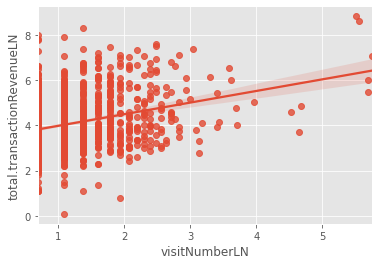

In [98]:
sns.regplot(
    data = df[df[TARGET]>0],
    x = 'visitNumberLN',
    y = TARGET_LN
)

### totals.hits


In [99]:
df['totals.hits'].describe()

count     90517
unique      160
top           1
freq      44863
Name: totals.hits, dtype: object

In [100]:
df['totals.hits'] = df['totals.hits'].astype(int)

In [101]:
df['totals.hits'].describe()

count    90517.000000
mean         4.634257
std          9.957356
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max        500.000000
Name: totals.hits, dtype: float64

In [102]:
# puede haber algun outlier, maximo 500. 
# std. --> raiz_quadrada((x-4.62)^2)


<AxesSubplot:xlabel='totals.hits', ylabel='total.transactionRevenueLN'>

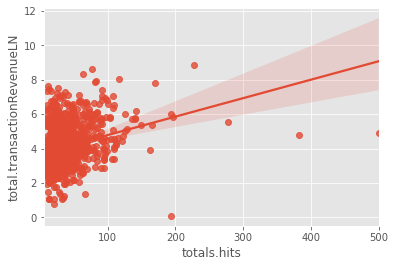

In [103]:
sns.regplot(
    data = df[df[TARGET]>0],
    x = 'totals.hits',
    y = TARGET_LN
)

In [104]:
df['totals.hitsLN'] = df['totals.hits'].apply(lambda x: np.log1p(x))

<AxesSubplot:xlabel='totals.hitsLN', ylabel='total.transactionRevenueLN'>

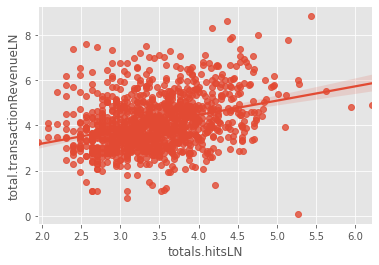

In [105]:
sns.regplot(
    data = df[df[TARGET]>0],
    x = 'totals.hitsLN',
    y = TARGET_LN
)

#### totals.pageviews


In [106]:
df['totals.pageviews'].describe()

count     90508
unique      124
top           1
freq      45403
Name: totals.pageviews, dtype: object

In [107]:
df['totals.pageviews'].dtype

dtype('O')

In [108]:
#es categorica, la tranformo
#hay nulos que hay que tratar primero
df['totals.pageviews'].fillna(0, inplace = True)
# df['totals.pageviews'].astype(int)

In [109]:
#imputacion de nulos: depende del algoritmo
    # decision tree: pongo valor extremo --> es robusto a la distribucion
    # regresion lineal, logistic regression, K-nn --> no puedo poner valor extremo, no son robustos a la distribucion

In [110]:
df['totals.pageviews'] = df['totals.pageviews'].astype(int)

<AxesSubplot:xlabel='totals.pageviews', ylabel='total.transactionRevenueLN'>

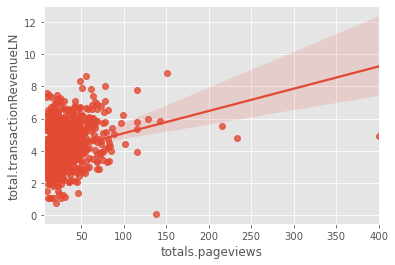

In [111]:
sns.regplot(
    data = df[df[TARGET]>0],
    x = 'totals.pageviews',
    y = TARGET_LN
)

In [112]:
df['totals.pageviewsLN'] = df['totals.pageviews'].apply(lambda x: np.log1p(x))

In [113]:
df[['totals.pageviewsLN','totals.hitsLN' ]].corr()

,totals.pageviewsLN,totals.hitsLN
totals.pageviewsLN,1.000000,0.991608
totals.hitsLN,0.991608,1.000000


In [114]:
# ante problemas de dimensiones , si hay dos variable muy correlacionadas >0.99, podeis eliminar una

### geoNetwork.continent

In [115]:
explore_cat_values(df, 'geoNetwork.continent')

,nrows,pct_rows,transaction,pct_transaction,mean_ln_revenue
geoNetwork.continent,,,,,
(not set),157,0.001734,1.0,0.006369,4.861439
Americas,44995,0.497089,1097.0,0.024380,4.114690
Asia,22423,0.247721,7.0,0.000312,4.154601
Europe,19900,0.219848,9.0,0.000452,3.885716
Oceania,1537,0.016980,2.0,0.001301,3.813843


In [116]:
# conclusiones:
    # america se distingue bastante
    # OHE claro

### geoNetwork.subContinent

In [117]:
explore_cat_values(df, 'geoNetwork.subContinent')

,nrows,pct_rows,transaction,pct_transaction,mean_ln_revenue
geoNetwork.subContinent,,,,,
(not set),157,0.001734,1.0,0.006369,4.861439
Australasia,1518,0.016770,2.0,0.001318,3.813843
Central America,1540,0.017013,3.0,0.001948,3.624751
Eastern Asia,4644,0.051305,4.0,0.000861,4.407393
Eastern Europe,4460,0.049273,1.0,0.000224,1.504077
Northern America,39103,0.431996,1082.0,0.027671,4.117692
Northern Europe,5751,0.063535,1.0,0.000174,3.496204
South America,4123,0.045549,12.0,0.002911,3.966503
Southeast Asia,7751,0.085630,1.0,0.000129,3.758406


### geoNetwork.country

In [118]:
results_by_country = explore_cat_values(df, 'geoNetwork.country')

In [119]:
last_countries = results_by_country[results_by_country['nrows'] > 500].sort_values(by = 'pct_transaction').head(5).index.to_list()

In [120]:
first_countries = results_by_country[results_by_country['nrows'] > 500].sort_values(by = 'pct_transaction').tail(5).index.to_list()

In [121]:
country_list = last_countries + first_countries

In [122]:
country_list

['United Kingdom',
 'Turkey',
 'France',
 'Australia',
 'Netherlands',
 'Taiwan',
 'Ukraine',
 'Colombia',
 'Canada',
 'United States']

In [123]:
country_list = set(country_list) #solo valores unicos

In [126]:
def setOthersPataNegra(dataframe, column, num_value, top_n):
    results_by_category = explore_cat_values(dataframe, column)
    last_cat = results_by_category[results_by_category['nrows'] > num_value].sort_values(by = 'pct_transaction').head(top_n).index.to_list()
    first_cat = results_by_category[results_by_category['nrows'] > num_value].sort_values(by = 'pct_transaction').tail(top_n).index.to_list()
    cat_list = last_cat + first_cat
    #cat_list = set(cat_list).to_list()

    cat_list.append('Others')
    
    dataframe[column] = pd.Categorical(dataframe[column], categories= cat_list)
    return dataframe[column].fillna('Others')

In [128]:
df['geoNetwork.country'] = setOthersPataNegra(df, 'geoNetwork.country', 500, 5)

### geoNetwork.city

In [130]:
explore_cat_values(df, 'geoNetwork.city')

,nrows,pct_rows,transaction,pct_transaction,mean_ln_revenue
geoNetwork.city,,,,,
(not set),3537,0.039076,3.0,0.000848,5.117841
Ann Arbor,237,0.002618,16.0,0.067511,4.041286
Atlanta,239,0.002640,12.0,0.050209,4.739664
Austin,393,0.004342,15.0,0.038168,4.055670
Berlin,129,0.001425,1.0,0.007752,5.549854
Boston,101,0.001116,2.0,0.019802,4.906655
Boulder,51,0.000563,1.0,0.019608,3.543565
Calgary,18,0.000199,1.0,0.055556,6.747704
Cambridge,153,0.001690,14.0,0.091503,4.348070


In [131]:
# min 100 observaciones para considerar una ciudad, solo 6 ciudades, las + rapresentativa
# solo las 3 primeras y las 3 ultimas
df['geoNetwork.city'] = setOthersPataNegra(df, 'geoNetwork.city', 500, 3)

## geoNetwork.metro

In [132]:
explore_cat_values(df, 'geoNetwork.metro')

,nrows,pct_rows,transaction,pct_transaction,mean_ln_revenue
geoNetwork.metro,,,,,
(not set),20157,0.222687,19.0,0.000943,4.434517
Atlanta GA,248,0.002740,12.0,0.048387,4.739664
Austin TX,393,0.004342,15.0,0.038168,4.055670
Boston MA-Manchester NH,263,0.002906,16.0,0.060837,4.417893
Charlotte NC,50,0.000552,1.0,0.020000,6.530265
Chicago IL,726,0.008021,42.0,0.057851,4.393858
Dallas-Ft. Worth TX,209,0.002309,3.0,0.014354,4.781651
Denver CO,89,0.000983,2.0,0.022472,5.111305
Detroit MI,252,0.002784,16.0,0.063492,4.041286


In [133]:
pd.crosstab(df['geoNetwork.metro'],df['geoNetwork.city'])

geoNetwork.city,London,(not set),Istanbul,New York,Chicago,Seattle,Others
geoNetwork.metro,,,,,,,
(not set),16,3537,628,0,0,0,15976
Abilene-Sweetwater TX,0,0,0,0,0,0,1
Albany-Schenectady-Troy NY,0,0,0,0,0,0,4
Atlanta GA,0,0,0,0,0,0,248
Austin TX,0,0,0,0,0,0,393
Baltimore MD,0,0,0,0,0,0,4
Boise ID,0,0,0,0,0,0,1
Boston MA-Manchester NH,0,0,0,0,0,0,263
Central Scotland,0,0,0,0,0,0,9


In [135]:
# la eliminamos porque se corelaciona con geoNetwork.city
df.drop('geoNetwork.metro', axis = 1, inplace = True)

In [136]:
pd.crosstab(df['geoNetwork.region'],df['geoNetwork.city'])

geoNetwork.city,London,(not set),Istanbul,New York,Chicago,Seattle,Others
geoNetwork.region,,,,,,,
(not set),0,2010,0,0,0,0,806
Abruzzo,0,0,0,0,0,0,1
Abu Dhabi,0,0,0,0,0,0,9
Adana,0,0,0,0,0,0,19
Al Madinah Province,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...
Wisconsin,0,0,0,0,0,0,61
Zhejiang,0,0,0,0,0,0,21
Zulia,0,0,0,0,0,0,21


In [138]:
# hay corelacion entre geoNetwork.city y geoNetwork.region
df.drop('geoNetwork.region', axis = 1, inplace = True)

## geoNetwork.networkDomain

In [139]:
df['geoNetwork.networkDomain'].head(10)

sessionId
1905672039242460897_1472817241    unknown.unknown
357659889600827884_1472839882     unknown.unknown
3053576296023059465_1472808484      asianet.co.th
602999120596767867_1472811390      threembb.co.uk
5280028223552107612_1472820135          (not set)
2569227522176957724_1472816790    unknown.unknown
1497348426098867699_1472808806          rapide.nl
8590648239310839049_1472835928           tpnet.pl
5637149591671308745_1472819775           aster.pl
3188126640915540925_1472841493         telenor.se
Name: geoNetwork.networkDomain, dtype: object

In [141]:
# con string siempre puedo sacar info del texto
df['networkDomain_net'] = df['geoNetwork.networkDomain'].str.contains('.uk', case = False).astype(int)

sessionId
1905672039242460897_1472817241    0
357659889600827884_1472839882     0
3053576296023059465_1472808484    0
602999120596767867_1472811390     1
5280028223552107612_1472820135    0
                                 ..
5139693001636159357_1483581821    0
8316382343226738015_1483549157    0
7822582517551956770_1483534287    0
015965500276524997_1483556696     0
7660319315190231588_1483548841    0
Name: geoNetwork.networkDomain, Length: 90517, dtype: int32

In [142]:
# si e sacado mucho string, puedo eliminar la variable
# de otra manera, podemos hacer un setOthers o swetOtherspatanegra
df.drop('geoNetwork.networkDomain', axis = 1, inplace = True) 

In [145]:
df.describe(exclude = np.number).T

,count,unique,top,freq
channelGrouping,90517,8,Organic Search,38261
device.browser,90517,4,Chrome,62003
device.operatingSystem,90517,7,Windows,35147
device.deviceCategory,90517,3,desktop,66665
geoNetwork.continent,90517,6,Americas,44995
geoNetwork.subContinent,90517,23,Northern America,39103
geoNetwork.country,90517,11,Others,39251
geoNetwork.city,90517,7,Others,81305


In [144]:
# miro que tenga poca etiqueta distintas que me permite hacer un OHE
df.describe(include = np.number).T

,count,mean,std,min,25%,50%,75%,max
visitNumber,90517.0,2.301104e+00,9.614016e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.940000e+02
visitStartTime,90517.0,1.484985e+09,9.022814e+06,1.470035e+09,1.477561e+09,1.483901e+09,1.492712e+09,1.501656e+09
totals.hits,90517.0,4.634257e+00,9.957356e+00,1.000000e+00,1.000000e+00,2.000000e+00,4.000000e+00,5.000000e+02
totals.pageviews,90517.0,3.873781e+00,7.205512e+00,0.000000e+00,1.000000e+00,1.000000e+00,4.000000e+00,4.000000e+02
totals.transactionRevenue,90517.0,1.827610e+00,4.626915e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.826960e+03
visitWithTransaction,90517.0,1.232918e-02,1.103508e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
total.transactionRevenueLN,90517.0,5.071265e-02,4.725935e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.828781e+00
Year,90517.0,2.016516e+03,4.997337e-01,2.016000e+03,2.016000e+03,2.017000e+03,2.017000e+03,2.017000e+03
Month,90517.0,6.988941e+00,3.485553e+00,1.000000e+00,4.000000e+00,7.000000e+00,1.000000e+01,1.200000e+01
Day,90517.0,1.564156e+01,8.826644e+00,1.000000e+00,8.000000e+00,1.600000e+01,2.300000e+01,3.100000e+01


# ML Data preparation - transformacion de variables

In [146]:
def OHE(dataframe, column_name):
    dummy_df = pd.get_dummies(dataframe[column_name], prefix = column_name)
    dataframe = pd.concat([dataframe,dummy_df],axis=1)
    # no hay el inplace -> nunca poner inplace dentro de funciones !!!
    return dataframe.drop(column, axis=1)


In [148]:
# .columns -> nombre de cada atributo
for column in df.describe(exclude = np.number).columns:
    df = OHE(df,column)

In [151]:
df.describe(include = np.number).T

,count,mean,std,min,25%,50%,75%,max
visitNumber,90517.0,2.301104e+00,9.614016e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.940000e+02
visitStartTime,90517.0,1.484985e+09,9.022814e+06,1.470035e+09,1.477561e+09,1.483901e+09,1.492712e+09,1.501656e+09
totals.hits,90517.0,4.634257e+00,9.957356e+00,1.000000e+00,1.000000e+00,2.000000e+00,4.000000e+00,5.000000e+02
totals.pageviews,90517.0,3.873781e+00,7.205512e+00,0.000000e+00,1.000000e+00,1.000000e+00,4.000000e+00,4.000000e+02
totals.transactionRevenue,90517.0,1.827610e+00,4.626915e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.826960e+03
visitWithTransaction,90517.0,1.232918e-02,1.103508e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
total.transactionRevenueLN,90517.0,5.071265e-02,4.725935e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.828781e+00
Year,90517.0,2.016516e+03,4.997337e-01,2.016000e+03,2.016000e+03,2.017000e+03,2.017000e+03,2.017000e+03
Month,90517.0,6.988941e+00,3.485553e+00,1.000000e+00,4.000000e+00,7.000000e+00,1.000000e+01,1.200000e+01
Day,90517.0,1.564156e+01,8.826644e+00,1.000000e+00,8.000000e+00,1.600000e+01,2.300000e+01,3.100000e+01


In [152]:
columns_related_to_target =['totals.transactionRevenue','visitWithTransaction']

In [154]:
df.drop(columns_related_to_target, axis = 1, inplace = True)

# empezamos con el modelling

### Separacion del dataset: 1. development/validacion 2. del development: train/test

#### 1. separar DEVELOPMENT y VALIDACION

In [155]:
df.pivot_table(index = ['Year','Month'], values = TARGET_LN)

total.transactionRevenueLN
Year Month                            
2016 8                        0.053856
     9                        0.046103
     10                       0.038678
     11                       0.034652
     12                       0.060094
2017 1                        0.044503
     2                        0.041354
     3                        0.058535
     4                        0.052581
     5                        0.077486
     6                        0.056057
     7                        0.059083
     8                        0.055077

In [156]:
# por VALIDATION SET esojemos siempre casi las mas recientes
df_val = df[df['Year']*100 + df['Month'] >= 201706 ] # desde junio incluido -> los ultimos meses -> VALIDACION
df_dev = df[df['Year']*100 + df['Month'] < 201706 ] # todo el resto en DEVELOPMENT

In [157]:
df_val_X = df_val.drop(TARGET_LN, axis=1) # no inplace, no quero modificar realmente
df_val_y = df_val[[TARGET_LN]] # doble corchete porque quiero un DATAFRAME y no una serie

df_dev_X = df_dev.drop(TARGET_LN, axis=1) # no inplace, no quero modificar realmente
df_dev_y = df_dev[[TARGET_LN]] # doble corchete porque quiero un DATAFRAME y no una serie

In [159]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    df_dev_X,
    df_dev_y,
    random_state = 42,
    test_size = 0.2
)

In [160]:
X_test.shape # suficiente observaciones para testear

(15347, 83)

# primer modelo

In [ ]:
# 1) ISTANCIAR el modelo
# n estimator muy grande tiende al OVERFITING, sino apriendo de valores muy concretos
first_model = xgb.XGBRFRegressor(random_sate = 42, max_depth = 4, n_estimator = 100)

In [ ]:
# 2) FITEAR el modelo
first_model.fit(X_train, y_train)

In [ ]:
# 3) PREDECIR (particion test)
# 4) EVALUAR

In [ ]:
pd.DataFrame(first_model.predict(X_test), columns = ['Predicition'], index = X_test.index)